# Average Gate Fidelity
Instead of performing process tomography on a system, it is possible to use a series of state tomographies and calculate an average gate fidelity from the measured density matices. To achieve this, the following equation can be used <cite data-cite="Nielsen_2002">(Nielsen_2002)</cite>:

$\begin{equation}\overline{F}(\mathcal{E}, U) = \frac{\sum_{jk}\alpha_{jk}tr(UU_j^{\dagger}U^{\dagger}\mathcal{E}(\rho_k))+d^2}{d^2(d+1)}\end{equation},$

where $\mathcal{E}(\rho_k) = \rho_k^\prime$ is the result from a single state tomography experiment with input $k$. This sum can then be evaluated using the input basis $\ket{0}$, $\ket{1}$, $\frac{\ket{0} + \ket{1}}{\sqrt{2}}$ & $\frac{\ket{0} + i\ket{1}}{\sqrt{2}}$ to determine an estimate for gate fidelity.

This notebook demonstates how the included GateFidelity object in Lightworks can be used to automate the process of gathering and analysing data to find the average gate fidelities.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lightworks as lw
from lightworks import emulator, qubit
from lightworks.tomography import GateFidelity

We'll define a run_experiments function which accepts the list of experiments and generates the results. In this example, an additional source_indistinguishability argument is included to allow for variation of this value, it defaults to a value of 1.

In [2]:
def run_experiments(
    experiments, source_indistinguishability: float = 1.0
) -> list:
    """
    Experiment function which is required for performing state tomography on a
    system. It takes a list of circuits and generates a corresponding list of
    results for each of them. Only supports one qubit systems currently.
    """
    # Post-select on 1 photon across each pair of qubit modes
    post_select = lw.PostSelection()
    post_select.add((0, 1), 1)
    post_select.add((2, 3), 1)

    backend = emulator.Backend("slos")

    # Use a batch to run all tasks at once
    batch = lw.Batch(
        lw.Sampler,
        task_args=[experiments.all_circuits, experiments.all_inputs, [20000]],
        task_kwargs={
            "source": [
                emulator.Source(
                    indistinguishability=source_indistinguishability
                )
            ],
            "post_selection": [post_select],
            "random_seed": [10],
        },
    )
    return backend.run(batch)

For this tutorial, the 2 qubit CNOT gate is used, which is created and shown below. A 90% loss is also included on each of the output channels.

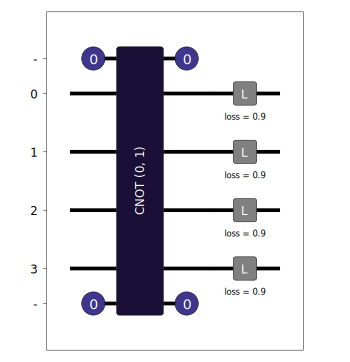

In [3]:
n_qubits = 2

cnot = qubit.CNOT()
for i in range(4):
    cnot.loss(i, 0.9)
cnot.display(display_loss=True)

## Ideal System
To measure the average gate fidelity, a new GateFidelity object is created with the required configuration and the experiments are then generated.

In [4]:
gate_f = GateFidelity(n_qubits, cnot)
experiments = gate_f.get_experiments()

We then run the experiments. Initially, we want to test an ideal system, so the photon indistinguishability is set to 1. 

In [5]:
results = run_experiments(experiments, 1.0)

The fidelity is then calculated with the process method. Unlike the other tomography approaches, the average gate fidelity requires knowledge of the expected unitary matrix for the gate. In the case of the CNOT gate, this is

\begin{equation} \text{U}_\text{cnot} = \begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{bmatrix},\end{equation}

which is encoded within the array below.

As expected, the calculated fidelity with an ideal system is nearly 100%.

In [6]:
u_cnot = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
avg_fidelity = gate_f.process(results, u_cnot)

print(f"Average gate fidelity = {avg_fidelity * 100} %")

Average gate fidelity = 99.84399999999998 %


## Photon Distinguishability

It is then possible to use the built-in noise modelling in Lightworks to simulate the likely effect that this has on the gate fidelity. A key limitation for gate fidelity is the extent to which photons are indistinguishable from each other, with distinguishability reducing overall fidelity.

To examine this effect, we sweep the photon indistinguishability from 80 to 100% and calculate the fidelity at each point. This is then plotted to view the relationship between the two quantities.

.. note:: This cell may take a while to execute (~1 min).

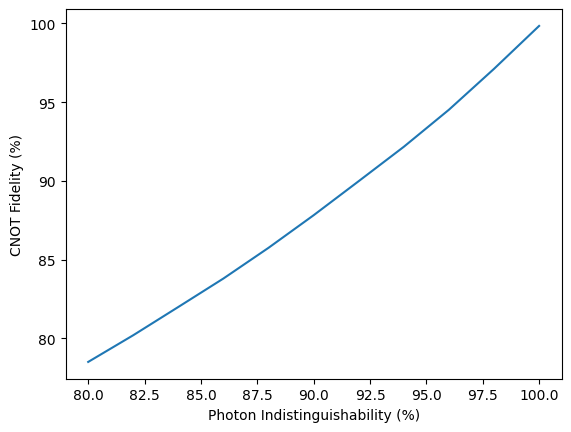

In [7]:
indistinguishability = range(80, 101, 2)

fidelities = []
for ind in indistinguishability:
    # Re-run experiments with new value
    results = run_experiments(experiments, ind / 100)
    # And then calculate fidelity
    fidelities.append(gate_f.process(results, u_cnot) * 100)

plt.plot(indistinguishability, fidelities)
plt.xlabel("Photon Indistinguishability (%)")
plt.ylabel("CNOT Fidelity (%)")
plt.show()

## State Fidelities
With any of the process tomography algorithms, it is also possible to take the collected data and find the output state fidelity matrices for the input basis used by the algorithms. While the gate fidelity is not strictly an average of these output state fidelities, it can be a useful way to understand how a system behaves in a range of different configurations.

To demonstrate this we will re-run the experiments created above with a source indistinguishability of 80%.

In [8]:
results = run_experiments(experiments, source_indistinguishability=0.8)

This data is then processed by the target process tomography algorithm. The return from this is a dictionary containing the input basis and the calculated state tomography fidelities. 

In [9]:
state_fidelities = gate_f.process_state_fidelities(results, u_cnot)
state_fidelities

{'Z+,Z+': np.float64(1.0000000004637002),
 'Z+,Z-': np.float64(1.0000000004018266),
 'Z+,X+': np.float64(1.000000021848882),
 'Z+,Y+': np.float64(1.0000000068731802),
 'Z-,Z+': np.float64(0.7113000005572717),
 'Z-,Z-': np.float64(0.7113000023718576),
 'Z-,X+': np.float64(1.0000000012883055),
 'Z-,Y+': np.float64(0.7113000113141975),
 'X+,Z+': np.float64(0.7476250008975734),
 'X+,Z-': np.float64(0.7476250000461714),
 'X+,X+': np.float64(0.7113000074420067),
 'X+,Y+': np.float64(0.7476250140993302),
 'Y+,Z+': np.float64(0.7476250109718067),
 'Y+,Z-': np.float64(0.747625000400505),
 'Y+,X+': np.float64(0.711300022334176),
 'Y+,Y+': np.float64(0.7476250281292963)}

This data can then be plotted to view the individual fidelities. 

As can be seen, despite the non-ideal photon indistinguishability some states are still generated with 100% fidelity. For the first 4 inputs, this occurs because there is no interference between photons when the first qubit is in the zero state (Z+), and so indistinguishability does not matter. The other case is Z-,X+ in which there is also no interference because the second qubit being input as X+ converts the gate from a CNOT to a CZ, we're then doing a CZ gate on the state |10>, which has no effect and so again no interference occurs.

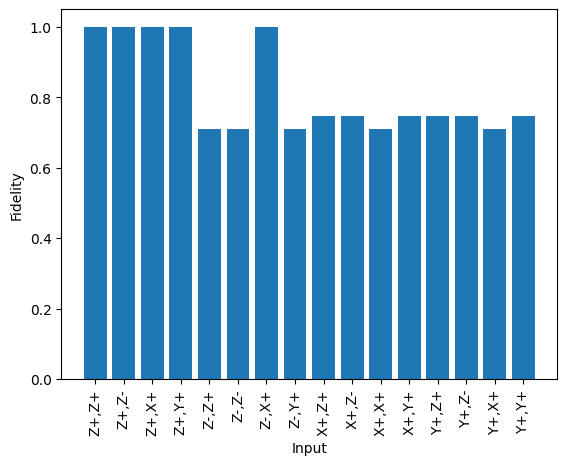

In [10]:
x = range(len(state_fidelities))

plt.bar(x, state_fidelities.values())
plt.xlabel("Input")
plt.ylabel("Fidelity")
plt.xticks(x, labels=state_fidelities, rotation=90)
plt.show()

## Projection to a physical process
The gate fidelity object also contains an option for projecting the calculated operators to a physical process. As the gate fidelity calculation uses a series of state tomographies, the physical projection is applied at this point and then these projected density matrices are passed into the equation for the gate fidelity calculation.

To demonstrate this projection, a tomography is performed on a T gate, with an intentionally low number of samples measured to introduce noise. It can be seen how in this case a fidelity of >100 % is calculated, which is a clear indication that the calculated density matrices are unphysical.

In [11]:
n_qubits = 1
t_gate = qubit.T()
u_t = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]])
n_samples = 400
seed = 1

gate_f = GateFidelity(n_qubits, t_gate)
experiments = gate_f.get_experiments()

results = [
    emulator.Backend("slos").run(
        lw.Sampler(exp.circuit, exp.input_state, n_samples, random_seed=seed)
    )
    for exp in experiments
]

f = gate_f.process(results, u_t)
print(f"Original fidelity = {f * 100:.3f} %")

Original fidelity = 100.961 %


The eigenvalues of the density matrices can also specifically checked with `check_eigenvalues`.

In [12]:
gate_f.check_eigenvalues(results)

{'Z+': array([-0.00124844,  1.00124844]),
 'Z-': array([-0.00124844,  1.00124844]),
 'X+': array([-0.04504587,  1.04504587]),
 'Y+': array([-0.02091266,  1.02091266])}

The fidelity is then recalculated using the `project_to_physical` option, and in this case a physical value is now seen.

.. note::
    Because of how the noise is introduced here the fidelity is likely to still not be accurate and may still be unphysical in some cases.

In [13]:
f2 = gate_f.process(results, u_t, project_to_physical=True)
print(f"Fidelity after projection = {f2 * 100:.3f} %")

Fidelity after projection = 98.727 %


Likewise the eigenvalues of the matrices can then be checked to confirm these are all non-negative (or effectively zero).

In [14]:
gate_f.check_eigenvalues(results, project_to_physical=True)

{'Z+': array([-8.67361738e-19,  1.00000000e+00]),
 'Z-': array([-2.16840434e-19,  1.00000000e+00]),
 'X+': array([-1.38777878e-16,  1.00000000e+00]),
 'Y+': array([1.38777878e-16, 1.00000000e+00])}